Epoch   1/120 | MSE: 0.693588
Epoch  10/120 | MSE: 0.041730
Epoch  20/120 | MSE: 0.031043
Epoch  30/120 | MSE: 0.027576
Epoch  40/120 | MSE: 0.025913
Epoch  50/120 | MSE: 0.026526
Epoch  60/120 | MSE: 0.025811
Epoch  70/120 | MSE: 0.025278
Epoch  80/120 | MSE: 0.025935
Epoch  90/120 | MSE: 0.024411
Epoch 100/120 | MSE: 0.024358
Epoch 110/120 | MSE: 0.023506
Epoch 120/120 | MSE: 0.021460


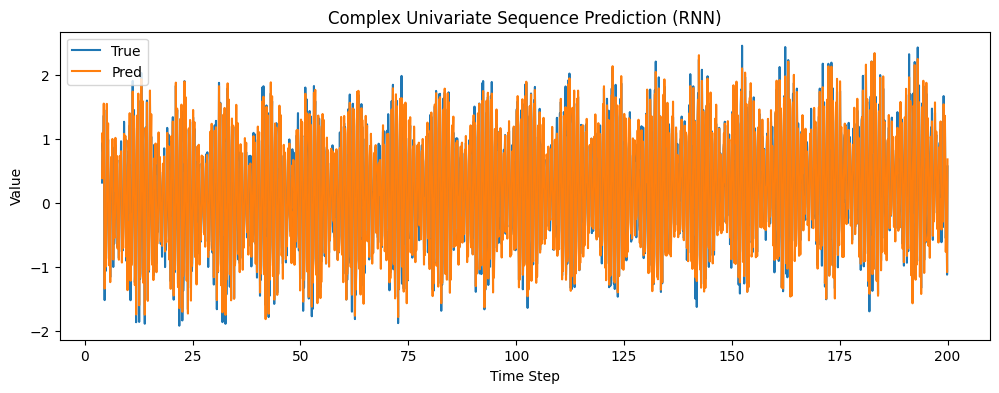

In [1]:
# ===================================================================
# 1) 라이브러리 임포트
# ===================================================================
import torch                              # PyTorch 메인 모듈
import torch.nn as nn                     # 신경망 계층 모듈
import torch.optim as optim               # 옵티마이저(Adam 등)
import numpy as np                        # 수치 계산 라이브러리
import matplotlib.pyplot as plt           # 결과 시각화
from torch.utils.data import TensorDataset, DataLoader

# ===================================================================
# 2) 재현성 확보를 위한 난수 시드 고정
# ===================================================================
torch.manual_seed(0)                      # PyTorch 난수 시드
np.random.seed(0)                         # NumPy  난수 시드

# ===================================================================
# 3) 하이퍼파라미터 설정
# ===================================================================
SEQ_LEN     = 40                          # 입력 시퀀스(슬라이딩 창) 길이
HIDDEN_SIZE = 64                          # RNN 은닉 상태 차원
NUM_LAYERS  = 1                           # RNN 스택 깊이
BATCH_SIZE  = 64                          # 학습 미니배치 크기
NUM_EPOCHS  = 120                         # 학습 epoch 수
LR          = 1e-3                        # Adam 학습률

# ===================================================================
# 4) 복잡한 단일-채널 시계열 데이터 생성
#    (여러 주파수+진폭 변조+추세+가우시안 노이즈)
# ===================================================================
t = np.linspace(0, 200, 2000, dtype=np.float32)      # 0~200 구간 2000 step 시간축

# --- 여러 사인/코사인 주파수 합성 ----------------------------------
signal  = np.sin(2*np.pi*1.0 * t)           # 1 Hz 사인파
signal += 0.6 * np.sin(2*np.pi*3.0 * t)     # 3 Hz 사인 (진폭 0.6)
signal += 0.3 * np.cos(2*np.pi*5.5 * t)     # 5.5 Hz 코사인 (진폭 0.3)

# --- 저주파로 진폭(amplitude) 변조 ---------------------------------
amp_mod = 1.0 + 0.4 * np.sin(2*np.pi*0.1 * t)  # 0.1 Hz 사인으로 진폭 변조 계수
signal *= amp_mod                              # 진폭 변조 적용

# --- 완만한 선형 추세(trend) ----------------------------------------
signal += 0.002 * t                            # 상승 추세 추가

# --- 가우시안 노이즈 -------------------------------------------------
signal += 0.1 * np.random.randn(*t.shape)      # σ=0.1 노이즈

# 단일-채널(univariate) → shape = (2000, 1) 로 변환
data = signal[:, np.newaxis]                   # 마지막에 채널 차원 추가

# ===================================================================
# 5) (입력 X, 타깃 y) 시퀀스 쌍 생성 함수
# ===================================================================
def make_sequences(arr, seq_len):              # 시퀀스 자동 생성
    xs, ys = [], []                            # 입력/타깃 리스트 초기화
    for i in range(len(arr) - seq_len):        # 슬라이딩 윈도우
        xs.append(arr[i : i + seq_len])        # 입력 시퀀스
        ys.append(arr[i + seq_len])            # 다음 1-스텝 값
    return np.stack(xs), np.stack(ys)          # 배열로 변환 후 반환

X, y = make_sequences(data, SEQ_LEN)    # 입력 시퀀스(슬라이딩 창) 길이       # (N, L, 1), (N, 1)

# ===================================================================
# 6) NumPy → PyTorch Tensor 변환 + DataLoader 구성
# ===================================================================
tensor_X = torch.from_numpy(X)                 # 입력 텐서
tensor_y = torch.from_numpy(y)                 # 타깃 텐서

dataset   = TensorDataset(tensor_X, tensor_y)        # Dataset
dataloader = DataLoader(dataset,                     # DataLoader
                    batch_size=BATCH_SIZE, shuffle=True)

# ===================================================================
# 7) 단일-채널 RNN 모델 정의 (입력/출력 모두 1)
# ===================================================================
class SimpleRNN(nn.Module):                                        # nn.Module 상속
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE,
                 num_layers=NUM_LAYERS, output_size=1):         # 생성자: 하이퍼 세팅
        super().__init__()                                      # 부모 초기화
        self.rnn = nn.RNN(input_size=input_size,                # Vanilla RNN 레이어
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)     # (batch, seq, feat) 포맷
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers=num_layers,
                            batch_first=True)           # batch_first=True
        self.fc  = nn.Linear(hidden_size, output_size)  # 은닉→스칼라

    def forward(self, x):                      # 순전파
        out, _ = self.rnn(x)                   # RNN 통과 (전체 출력, h_n)
        # out, _ = self.lstm(x)                  # LSTM 통과 (전체 출력, h_n)
        out = out[:, -1, :]                    # 마지막 타임스텝 은닉만 선택
        out = self.fc(out)                     # FC 통해 최종 스칼라 예측
        return out                             # 출력 반환

# ----- 모델 & 디바이스(GPU/CPU) 설정 -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = SimpleRNN().to(device)                   # 모델을 디바이스로 이동

# ===================================================================
# 8) 손실 함수(MSE)와 옵티마이저(Adam) 정의
# ===================================================================
criterion = nn.MSELoss()                       # 평균제곱오차
optimizer = optim.Adam(model.parameters(), lr=LR)  # Adam 옵티마이저

# ===================================================================
# 9) 학습 루프
# ===================================================================
for epoch in range(1, NUM_EPOCHS + 1):         # 에폭 반복
    model.train()                              # 학습 모드
    epoch_loss = 0.0                           # 손실 누적 변수
    for batch_X, batch_y in dataloader:        # 미니배치 순회
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # GPU 이동

        optimizer.zero_grad()                  # 기울기 0 으로 초기화
        preds = model(batch_X)                 # 순전파 예측
        loss  = criterion(preds, batch_y)      # 손실 계산
        loss.backward()                        # 역전파
        optimizer.step()                       # 파라미터 업데이트

        epoch_loss += loss.item() * batch_X.size(0) # 배치 손실 합

    epoch_loss /= len(dataset)                 # 평균 손실
    if epoch % 10 == 0 or epoch == 1:          # 로그 출력 주기
        print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | MSE: {epoch_loss:.6f}")

# ===================================================================
# 10) 트레이닝 후 전체 시퀀스 예측 & 시각화
# ===================================================================
model.eval()                                   # 평가 모드
with torch.no_grad():                          # 기울기 비활성
    preds = model(torch.from_numpy(X).to(device)).cpu().numpy()  # 전체 예측

plt.figure(figsize=(12, 4))                    # 그래프 크기
plt.plot(t[SEQ_LEN:], data[SEQ_LEN:, 0], label='True')    # 실제 곡선
plt.plot(t[SEQ_LEN:], preds.squeeze(), label='Pred')      # 예측 곡선
plt.title("Complex Univariate Sequence Prediction (RNN)") # 제목
plt.xlabel("Time Step")                        # x축 라벨
plt.ylabel("Value")                            # y축 라벨
plt.legend()                                   # 범례
plt.show()                                     # 그래프 출력

In [2]:
import torch                       # 파이토치 모듈 불러옴

# 필수 라이브러리 설치 --------------------------------------------------------
!pip install -q sentence-transformers # Sentence-Transformers 패키지 설치

# 모듈 임포트 -----------------------------------------------------------------
from sentence_transformers import SentenceTransformer  # SBERT 모델 클래스
from sklearn.metrics.pairwise import cosine_similarity # 코사인 유사도 계산 함수

# 사전 학습된 한국어 SBERT 모델 로드 -----------------------------------------
model = SentenceTransformer(
    'snunlp/KR-SBERT-V40K-klueNLI-augSTS'  # 공개 한국어 SBERT 체크포인트
)  # 모델은 처음 호출 시 HF Hub 에서 다운받음

# 데모용 한국어 문장 리스트 정의 ----------------------------------------------
sentences = [                                   # 임베딩을 얻을 예시 문장들
    "삼성동에서 근무하고 있습니다.",                # 문장 0
    "삼성동에서 밥먹고 있습니다.",           # 문장 1
    "강남역 근처 맛집을 추천합니다.",               # 문장 2
    "오늘 날씨가 매우 덥다.",                      # 문장 3
    "자연어 처리는 흥미로운 분야이다."             # 문장 4
]

# 문장 → 벡터 임베딩 변환 ------------------------------------------------------
embeddings = model.encode(sentences)   # shape: (문장 개수, 768)

# 임베딩 크기 및 타입 확인 -----------------------------------------------------
print(embeddings.shape)               # (5, 768) 형태 확인
print(type(embeddings))               # numpy.ndarray 타입

# 문장 0과 1의 유사도 계산 ----------------------------------------------------
sim01 = cosine_similarity(            # 두 벡터 간 코사인 유사도 계산
    [embeddings[0]],                  # 문장 0 임베딩
    [embeddings[1]]                   # 문장 1 임베딩
)[0][0]                               # 결과 스칼라 추출
print(f"문장 0-1 유사도: {sim01:.4f}")  # 소수점 4자리까지 출력

# 전체 유사도 행렬 계산 및 시각적 확인 ----------------------------------------
sim_matrix = cosine_similarity(embeddings, embeddings)  # (5,5) 유사도 행렬
import pandas as pd                 # 데이터프레임 시각화를 위해 pandas 사용
pd.DataFrame(sim_matrix,            # 행렬 → DataFrame 변환
             index=[f"S{i}" for i in range(len(sentences))],
             columns=[f"S{i}" for i in range(len(sentences))])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(5, 768)
<class 'numpy.ndarray'>
문장 0-1 유사도: 0.6930


,S0,S1,S2,S3,S4
S0,1.000000,0.692981,0.270575,0.032675,0.120861
S1,0.692981,1.000000,0.283166,0.061965,0.111401
S2,0.270575,0.283166,1.000000,0.045874,0.196305
S3,0.032675,0.061965,0.045874,1.000000,0.104219
S4,0.120861,0.111401,0.196305,0.104219,1.000000


In [3]:
# 필수 라이브러리 설치 --------------------------------------------------------
!pip install -q konlpy scikit-learn  # konlpy와 scikit-learn 설치

# 모듈 임포트 -----------------------------------------------------------------
from konlpy.tag import Okt # Okt 형태소 분석기 임포트
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF 벡터화
from sklearn.metrics.pairwise import cosine_similarity # 코사인 유사도 계산

# Okt 형태소 분석기 인스턴스 생성 ---------------------------------------------
okt = Okt()

# 간단한 한글 코퍼스 준비 -----------------------------------------------------
raw_corpus = [                                   # 샘플 문장 10개
    "나는 오늘도 파이썬을 공부한다",
    "자연어 처리는 정말 재미있다",
    "머신러닝 모델이 점점 좋아진다",
    "딥러닝은 데이터가 중요하다",
    "삼성동에는 맛있는 밥집이 많다",
    "강남역에서 친구를 만났다",
    "커피 한 잔이 기분을 좋게 한다",
    "스포츠는 건강에 도움이 된다",
    "영화를 보면 감성이 풍부해진다",
    "독서는 지식을 확장시킨다"
]

# 형태소 분석 및 명사 추출 ----------------------------------------------------
tokenized_corpus = []
for sentence in raw_corpus:
    # 명사만 추출하여 공백으로 조인
    tokens = okt.nouns(sentence)
    tokenized_corpus.append(" ".join(tokens))

print("형태소 분석 결과 (명사 추출):")
for tokens in tokenized_corpus:
    print(tokens)
print("-" * 20)

# TF-IDF 벡터화 --------------------------------------------------------------
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tokenized_corpus)

print("TF-IDF 행렬 형태:", tfidf_matrix.shape)
print("-" * 20)

# 코사인 유사도 계산 ---------------------------------------------------------
# 모든 문장 쌍에 대한 유사도 행렬 계산
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("Original Sentences:")
for i, sentence in enumerate(raw_corpus):
    print(f"Doc{i}: {sentence}")

print("코사인 유사도 행렬:")
import pandas as pd # 데이터프레임 시각화를 위해 pandas 사용
pd.DataFrame(cosine_sim_matrix,
             index=[f"Doc{i}" for i in range(len(raw_corpus))],
             columns=[f"Doc{i}" for i in range(len(raw_corpus))])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 34.1 MB/s eta 0:00:00
형태소 분석 결과 (명사 추출):
나 오늘 파이썬 공부
자연어 처리 정말
머신 러닝 모델 점점
딥 러닝 데이터
삼성동 밥집
강남역 친구
커피 잔 기분
스포츠 건강 도움
영화 감성
독서 지식 확장
--------------------
TF-IDF 행렬 형태: (10, 25)
--------------------
Original Sentences:
Doc0: 나는 오늘도 파이썬을 공부한다
Doc1: 자연어 처리는 정말 재미있다
Doc2: 머신러닝 모델이 점점 좋아진다
Doc3: 딥러닝은 데이터가 중요하다
Doc4: 삼성동에는 맛있는 밥집이 많다
Doc5: 강남역에서 친구를 만났다
Doc6: 커피 한 잔이 기분을 좋게 한다
Doc7: 스포츠는 건강에 도움이 된다
Doc8: 영화를 보면 감성이 풍부해진다
Doc9: 독서는 지식을 확장시킨다
코사인 유사도 행렬:


,Doc0,Doc1,Doc2,Doc3,Doc4,Doc5,Doc6,Doc7,Doc8,Doc9
Doc0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Doc1,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Doc2,0.0,0.0,1.000000,0.285368,0.0,0.0,0.0,0.0,0.0,0.0
Doc3,0.0,0.0,0.285368,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
Doc4,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
Doc5,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
Doc6,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
Doc7,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
Doc8,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
Doc9,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
preds.shape

(1960, 1)

In [5]:
print("Original Sentences:")
for i, sentence in enumerate(raw_corpus):
    print(f"Doc{i}: {sentence}")

Original Sentences:
Doc0: 나는 오늘도 파이썬을 공부한다
Doc1: 자연어 처리는 정말 재미있다
Doc2: 머신러닝 모델이 점점 좋아진다
Doc3: 딥러닝은 데이터가 중요하다
Doc4: 삼성동에는 맛있는 밥집이 많다
Doc5: 강남역에서 친구를 만났다
Doc6: 커피 한 잔이 기분을 좋게 한다
Doc7: 스포츠는 건강에 도움이 된다
Doc8: 영화를 보면 감성이 풍부해진다
Doc9: 독서는 지식을 확장시킨다
